In [1]:
import pathlib
import os, sys
import numpy as np
from loguru import logger
from collections import defaultdict
from openset_imagenet.util import ccr_at_fpr
import openset_imagenet
from matplotlib import pyplot

In [2]:
def load_scores(args):
    # we sort them as follows: protocol, loss, algorithm
    scores = defaultdict(lambda: defaultdict(dict))
    ground_truths = {}
    for i in range (6, 501):
        for net in ["random"]:
                score_file = f"bce_binary_ensemble_combined_imagenet_test_arr_curr_{net}_{i}.npz"
                if os.path.exists(score_file):
                    # remember files
                    results = np.load(score_file)
                    scores[score_file] = results["scores"] # only change in maxlogits case

                    if len(ground_truths) == 0:
                        ground_truths = results["gt"].astype(int)
                    else:
                        assert np.all(results["gt"] == ground_truths)

                    logger.info(f"Loaded score file {score_file} for net {net}")
                else:
                    logger.warning(f"Did not find score file {score_file} for net {net}")

    return scores, ground_truths

In [3]:
THRESHOLDS = {
              1e-3: "$10^{-3}$",
              1e-2: "$10^{-2}$",
              1e-1: "$10^{-1}$",
              1: "$1$",
}

scores, ground_truths = load_scores(None)
random_ccrs = []
hamming_ccrs = []
# we get ccr@fpr for each network
for i in range (6, 501):
    for net in ["random"]:
        full_net = f"bce_binary_ensemble_combined_imagenet_test_arr_curr_{net}_{i}.npz"
        ccrs = ccr_at_fpr(ground_truths, scores[full_net], THRESHOLDS)
        ccrs_sum = 0
        for ccr in ccrs:
            if type(ccr) != type(None):
                ccrs_sum += ccr
        if net == "random":
            random_ccrs.append(ccrs_sum)
        else:
            hamming_ccrs.append(ccrs_sum)
        logger.info(f"Network {full_net}: {ccrs_sum} for thresholds {THRESHOLDS.values()}")

2024-06-01 17:01:25.652 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_6.npz for net random
2024-06-01 17:01:25.658 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_7.npz for net random
2024-06-01 17:01:25.663 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_8.npz for net random
2024-06-01 17:01:25.668 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_9.npz for net random
2024-06-01 17:01:25.673 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_10.npz for net random
2024-06-01 17:01:25.678 | INFO     | __main__:load_scores:18 - Loaded score file bce_binary_ensemble_combined_imagenet_test_arr_curr_random_11.npz for net random
2024-06-01 17:01:25.684 | INFO  

In [4]:
print(random_ccrs)

for i, x in enumerate(random_ccrs):
    if x > 1.075:
        print(i, x)
        break

[1.0402823920265782, 1.0458194905869325, 1.0539867109634553, 1.0544019933554818, 1.0563399778516058, 1.0592469545957919, 1.0645071982281284, 1.0717054263565893, 1.071705426356589, 1.0711517165005537, 1.0728128460686601, 1.0766888150609082, 1.0754429678848285, 1.0775193798449612, 1.0757198228128462, 1.0751661129568106, 1.0771040974529347, 1.0787652270210408, 1.0775193798449612, 1.075858250276855, 1.0743355481727574, 1.0771040974529347, 1.0773809523809526, 1.0779346622369879, 1.0761351052048727, 1.075858250276855, 1.076688815060908, 1.074750830564784, 1.074750830564784, 1.0735049833887045, 1.0755813953488373, 1.0753045404208195, 1.0751661129568106, 1.073920265780731, 1.074750830564784, 1.073920265780731, 1.0740586932447398, 1.0740586932447398, 1.0771040974529347, 1.0754429678848283, 1.0754429678848285, 1.0740586932447398, 1.073920265780731, 1.0784883720930232, 1.0759966777408638, 1.0751661129568106, 1.0736434108527133, 1.0744739756367663, 1.0733665559246954, 1.072951273532669, 1.07253599

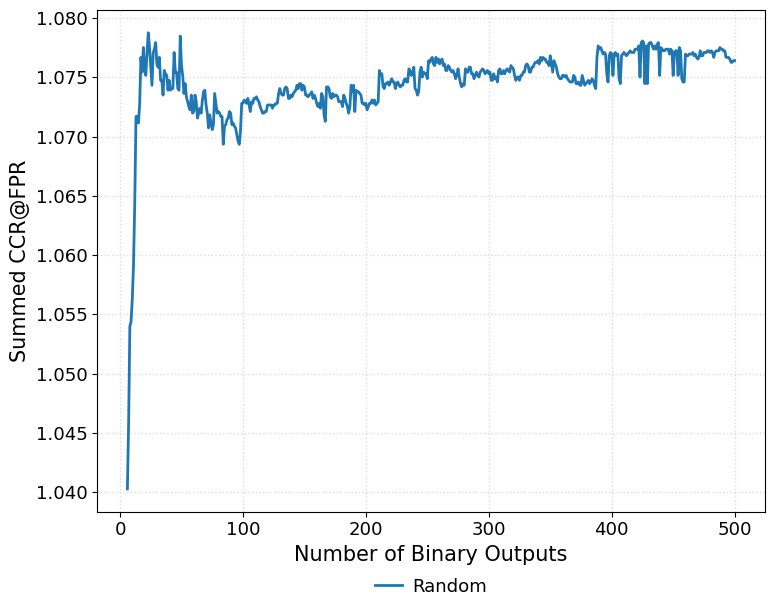

In [5]:
import matplotlib.pyplot as plt

# Set font properties
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15}
plt.rc('font', **font)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the data
ax.plot(range(6, 501), random_ccrs, label="Random", linewidth=2)
# ax.plot(range(4, 127), hamming_ccrs, label="Hamming", linewidth=2)

# Set axis labels
ax.set_xlabel('Number of Binary Outputs', fontsize=15)
ax.set_ylabel('Summed CCR@FPR', fontsize=15)

# Set y-axis range from 0 to 4
#ax.set_ylim(1.4, 1.6)

# Set grid properties
ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
ax.grid(axis='y', linestyle=':', linewidth=1, color='gainsboro')

# Set axis ticks
ax.tick_params(axis='both', which='major', labelsize=13)

# Adjust layout
plt.tight_layout()

# Set legend below the plot
plt.legend(frameon=False, fontsize=13, handlelength=1.5, handletextpad=0.6, columnspacing=1.5, loc='lower center', bbox_to_anchor=(0.5, -0.20), ncol=2)

# Display the plot
plt.savefig("ex_5_ccr_fpr.pdf", bbox_inches='tight')
plt.show()